# Scikit-Learn Models
This notebook showcases the scalecast wrapper around scikit-learn models.  

The data is available for download here: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
See the blog post: https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558  

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.auxmodels import mlp_stack
from tqdm.notebook import tqdm
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option('max_colwidth',500)
pd.set_option('display.max_rows',500)

In [2]:
def plot_test_export_summaries(f):
    """ exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAPE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAPE',
            'TestSetR2',
            'InSampleMAPE',
            'InSampleR2'
        ]
    ]

We will bring in the default grids from scalecast and tune some of our models this way. For others, we will create our own grids.

In [3]:
GridGenerator.get_example_grids()

In [4]:
data = pd.read_csv('daily-website-visitors.csv')
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582",1430,152
1,2,Monday,2,9/15/2014,"3,621","2,528",2297,231
2,3,Tuesday,3,9/16/2014,"3,698","2,630",2352,278
3,4,Wednesday,4,9/17/2014,"3,667","2,614",2327,287
4,5,Thursday,5,9/18/2014,"3,316","2,366",2130,236


In [5]:
data.shape

(2167, 8)

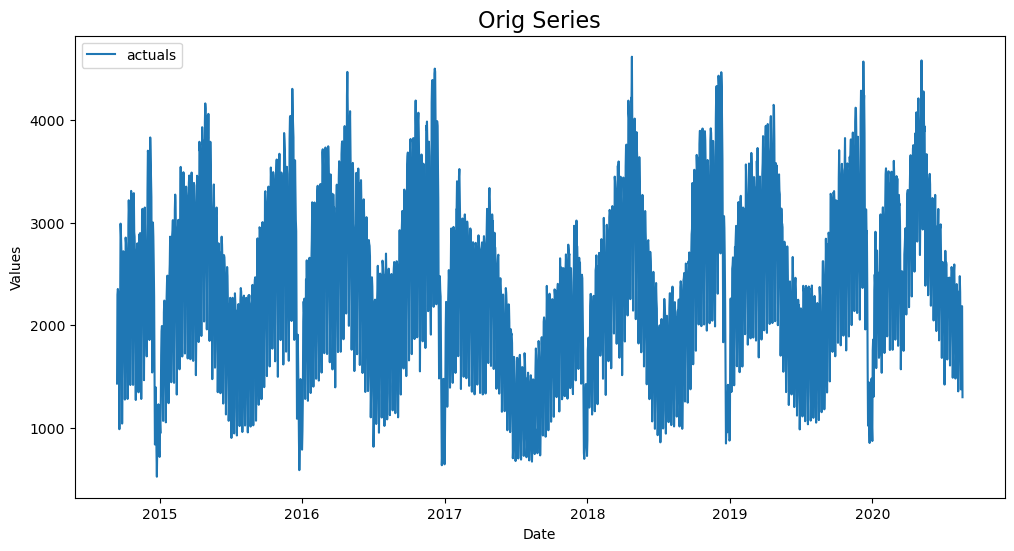

In [6]:
f=Forecaster(y=data['First.Time.Visits'],current_dates=data['Date'])
f.plot()
plt.title('Orig Series',size=16)
plt.show()

Not all models we will showcase come standard in scalecast, but we can easily add them by using the code below:

In [7]:
f.add_sklearn_estimator(BaggingRegressor,'bagging')
f.add_sklearn_estimator(StackingRegressor,'stacking')

For more EDA on this dataset, see the prophet example: https://scalecast-examples.readthedocs.io/en/latest/prophet/prophet.html#EDA

## Prepare Forecast
- 60-day forecast horizon
- 20% test split
- Turn confidence intervals on
- Add time series regressors:
- 7 autoregressive terms  
  - 4 seasonal autoregressive terms spaced 7-periods apart  
  - month, quarter, week, and day of year with a fournier transformation  
  - dayofweek, leap year, and week as dummy variables  
  - year  

In [8]:
fcst_length = 60
f.generate_future_dates(fcst_length)
f.set_test_length(.2)
f.eval_cis() # tell the object to build confidence intervals for all models
f.add_ar_terms(7)
f.add_AR_terms((4,7))
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'is_leap_year_True', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', '

## MLR
- use default parameters (which means all input vars are scaled with a minmax scaler by default for all sklearn models)

In [9]:
f.set_estimator('mlr')
f.manual_forecast()

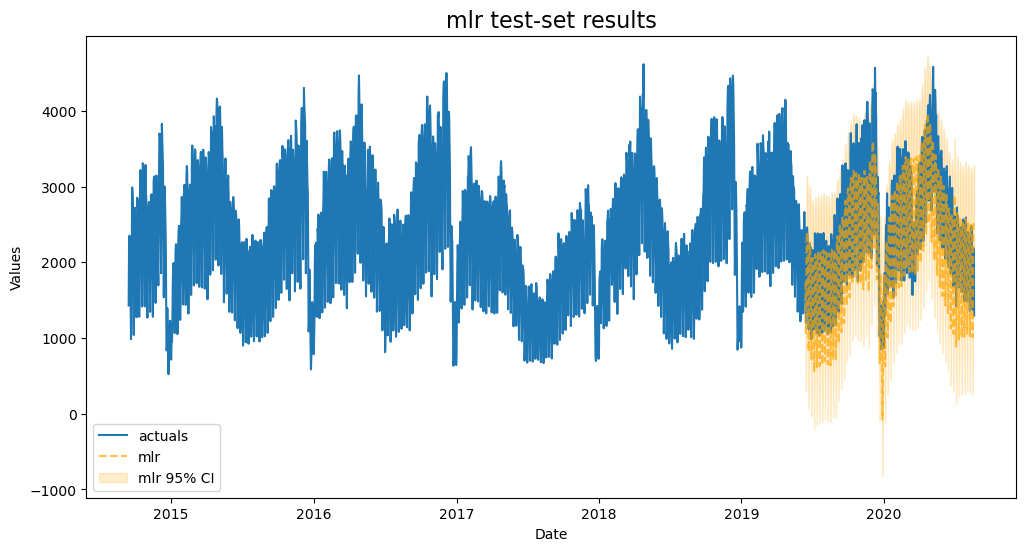

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.14485,0.733553,0.064183,0.953482


In [10]:
plot_test_export_summaries(f)

## Lasso
- tune alpha with 100 choices using 3-fold cross validation

In [11]:
f.set_estimator('lasso')
lasso_grid = {'alpha':np.linspace(0,2,100)}
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast()

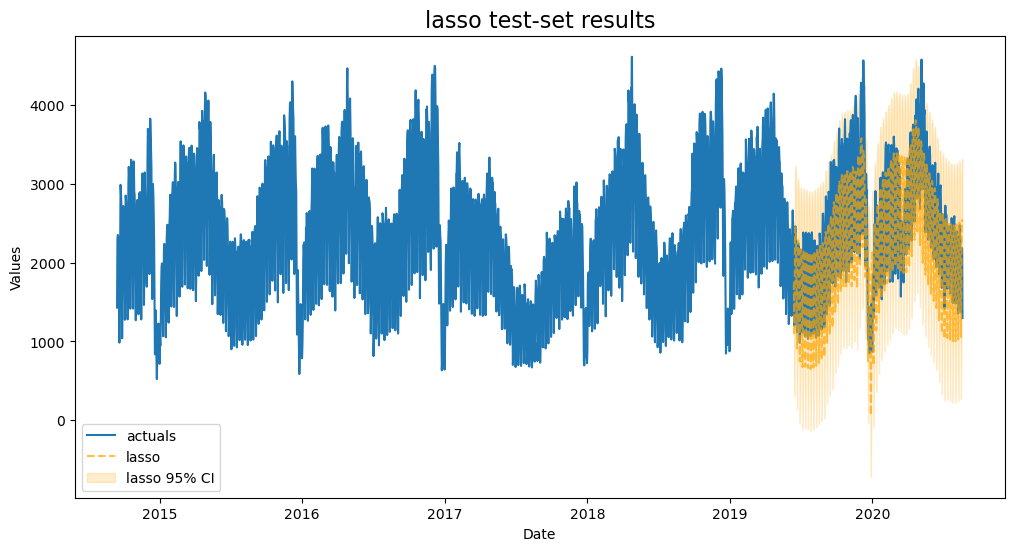

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
1,mlr,{},0.144850,0.733553,0.064183,0.953482


In [12]:
plot_test_export_summaries(f)

## Ridge
- tune alpha with the same grid used for lasso

In [13]:
f.set_estimator('ridge')
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast()

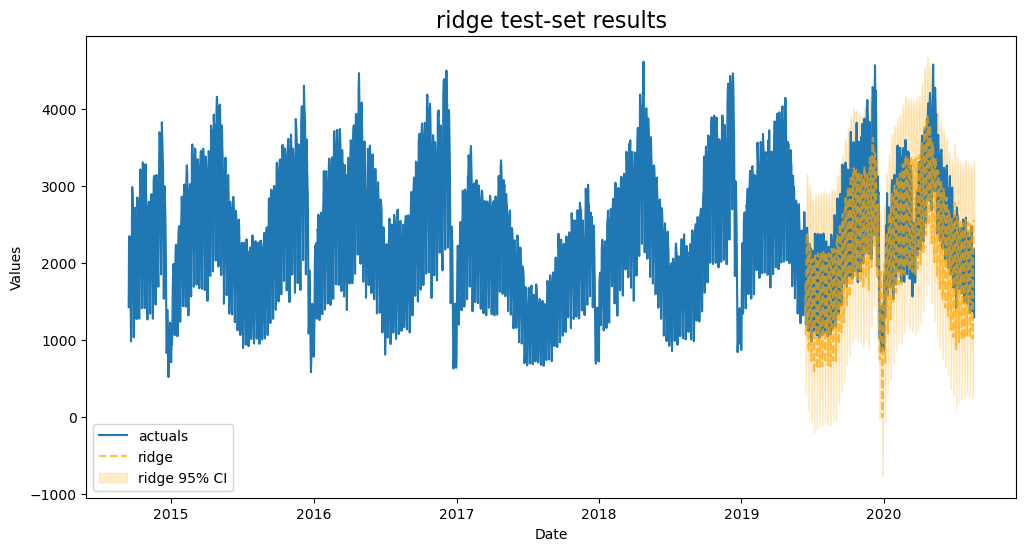

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
1,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
2,mlr,{},0.144850,0.733553,0.064183,0.953482


In [14]:
plot_test_export_summaries(f)

## Elasticnet

- this model mixes L1 and L2 regularization parameters
- its default grid is pretty good for finding the optimal alpha value and l1 ratio

In [15]:
f.set_estimator('elasticnet')
f.cross_validate(k=3)
f.auto_forecast()

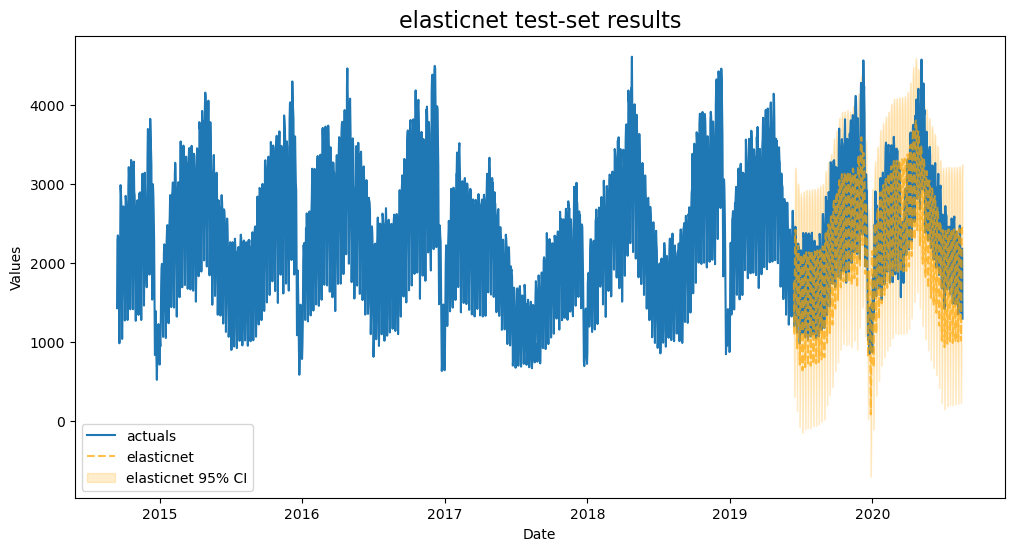

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
1,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
2,elasticnet,"{'alpha': 2.0, 'l1_ratio': 1, 'normalizer': 'scale'}",0.141774,0.733125,0.065364,0.952024
3,mlr,{},0.144850,0.733553,0.064183,0.953482


In [16]:
plot_test_export_summaries(f)

## RF
![Random Forest](rf.png)

create a grid to tune Random Forest with more options than what is available in the default grids

In [17]:
f.set_estimator('rf')
rf_grid = {
    'max_depth':[2,3,4,5],
    'n_estimators':[100,200,500],
    'max_features':['auto','sqrt','log2'],
    'max_samples':[.75,.9,1],
}
f.ingest_grid(rf_grid)
f.cross_validate(k=3)
f.auto_forecast()

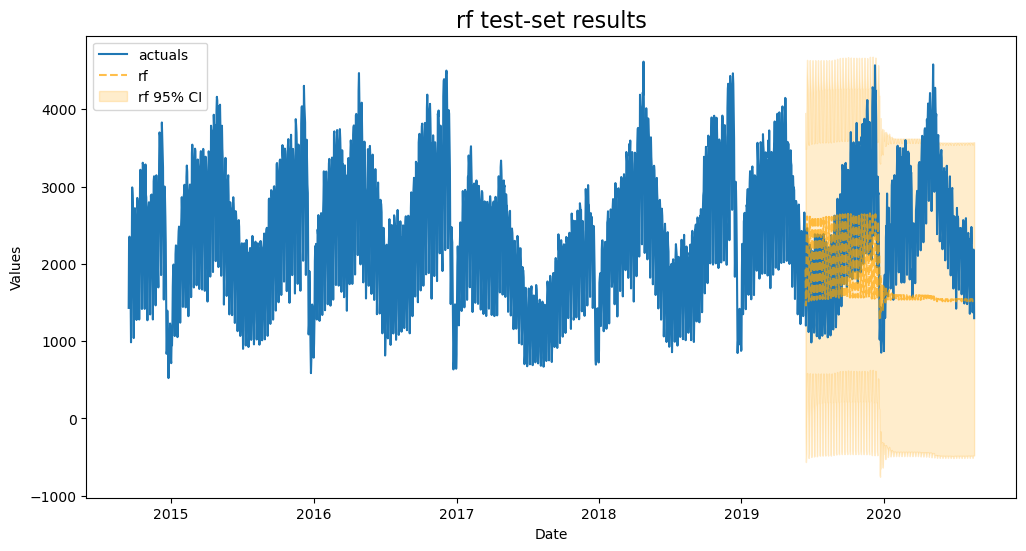

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
1,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
2,mlr,{},0.144850,0.733553,0.064183,0.953482
3,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
4,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [18]:
plot_test_export_summaries(f)

So far, both using a visual inspection and examing its test-set performance, Random Forest does worse than all others.

## XGBoost
- Build a grid to tune XGBoost

In [19]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2],
     'gamma':[0,3,5], 
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.cross_validate(k=3)
f.auto_forecast()

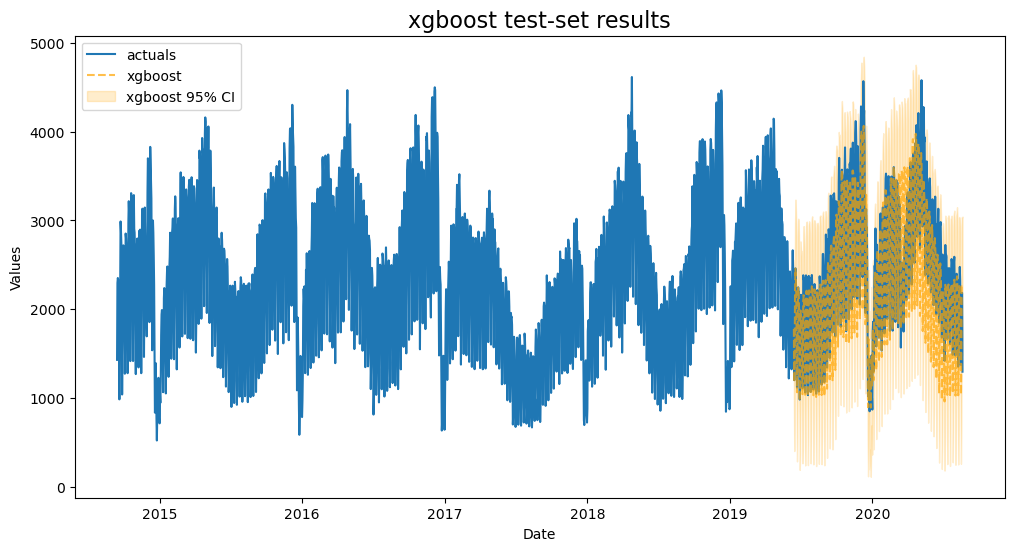

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
2,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
3,mlr,{},0.144850,0.733553,0.064183,0.953482
4,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
5,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [20]:
plot_test_export_summaries(f)

This is our best model so far using the test MAPE as the metric to determine that by. It appears to be also be highly overfit.

## LightGBM
- Build a grid to tune LightGBM

In [21]:
f.set_estimator('lightgbm')
lightgbm_grid = {
    'n_estimators':[150,200,250],
    'boosting_type':['gbdt','dart','goss'],
    'max_depth':[1,2,3],
    'learning_rate':[0.001,0.01,0.1],
    'reg_alpha':np.linspace(0,1,5),
    'reg_lambda':np.linspace(0,1,5),
    'num_leaves':np.arange(5,50,5),
}
f.ingest_grid(lightgbm_grid)
f.limit_grid_size(100,random_seed=2)
f.cross_validate(k=3)
f.auto_forecast()

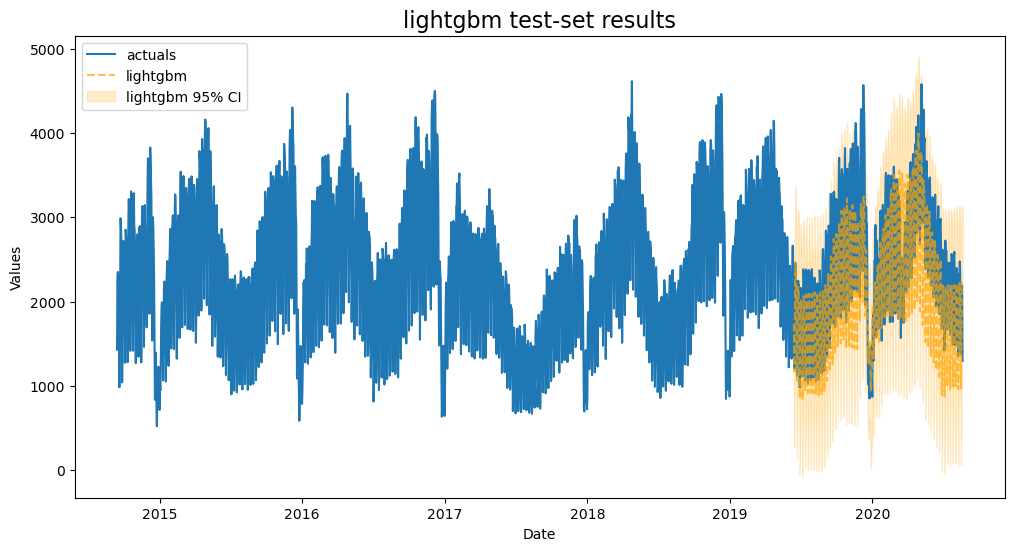

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
2,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
3,mlr,{},0.144850,0.733553,0.064183,0.953482
4,lightgbm,"{'n_estimators': 200, 'boosting_type': 'goss', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0.25, 'reg_lambda': 1.0, 'num_leaves': 35}",0.166747,0.592318,0.050726,0.970159
5,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
6,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [22]:
plot_test_export_summaries(f)

## SGD
- Use the default Stochastic Gradient Descent grid

In [23]:
f.set_estimator('sgd')
f.cross_validate(k=3)
f.auto_forecast()

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


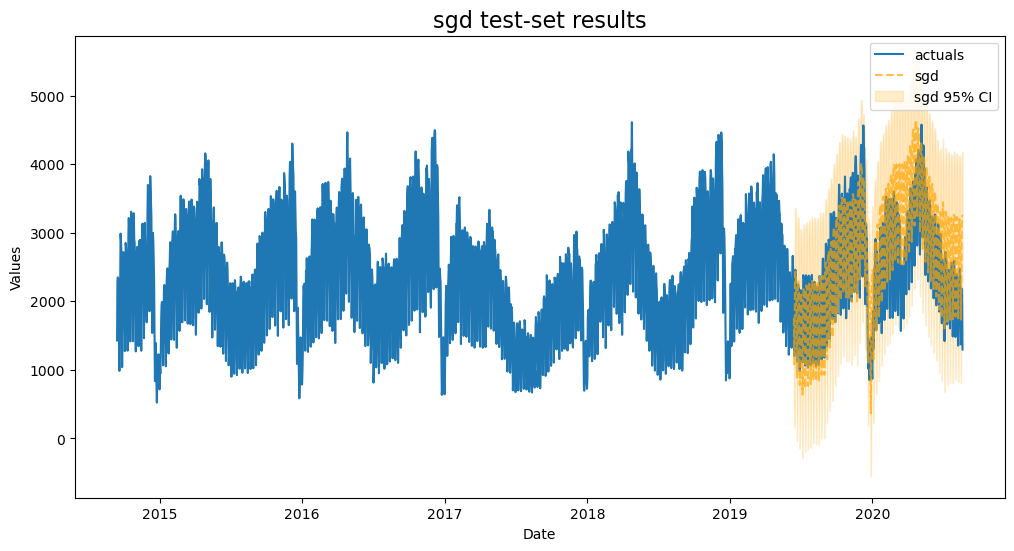

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
2,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
3,mlr,{},0.144850,0.733553,0.064183,0.953482
4,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 1, 'learning_rate': 'constant'}",0.166129,0.609554,0.065153,0.951795
5,lightgbm,"{'n_estimators': 200, 'boosting_type': 'goss', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0.25, 'reg_lambda': 1.0, 'num_leaves': 35}",0.166747,0.592318,0.050726,0.970159
6,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
7,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [24]:
plot_test_export_summaries(f)

## KNN
- Use the default K-nearest Neighbors grid

In [25]:
f.set_estimator('knn')
f.cross_validate(k=3)
f.auto_forecast()

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


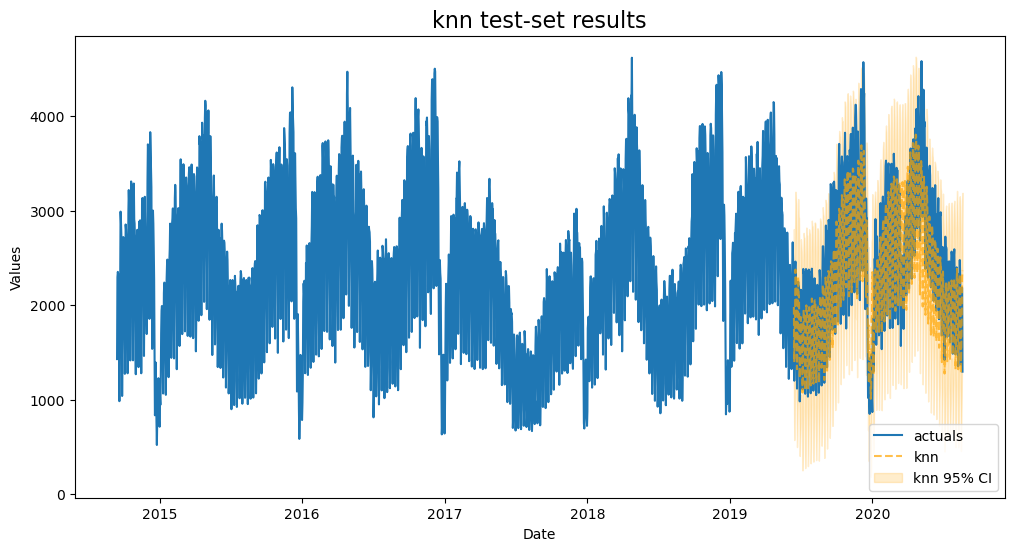

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,knn,"{'n_neighbors': 20, 'weights': 'uniform'}",0.130121,0.713268,0.117198,0.873220
2,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
3,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
4,mlr,{},0.144850,0.733553,0.064183,0.953482
5,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 1, 'learning_rate': 'constant'}",0.166129,0.609554,0.065153,0.951795
6,lightgbm,"{'n_estimators': 200, 'boosting_type': 'goss', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0.25, 'reg_lambda': 1.0, 'num_leaves': 35}",0.166747,0.592318,0.050726,0.970159
7,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
8,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [26]:
plot_test_export_summaries(f)

KNN is our most overfit model so far, but it fits the test-set pretty well.

## BaggingRegressor
- Like Random Forest is a bagging ensemble model using decision trees, we can use a bagging estimator that uses a three-layered mulit-level perceptron to see if the added complexity improves where the Random Forest couldn't

In [28]:
f.set_estimator('bagging')
f.manual_forecast(
    base_estimator = MLPRegressor(
        hidden_layer_sizes=(100,100,100)
        ,solver='lbfgs'
    ),
    max_samples = 0.9,
    max_features = 0.5,
)

Finished loading model, total used 200 iterations


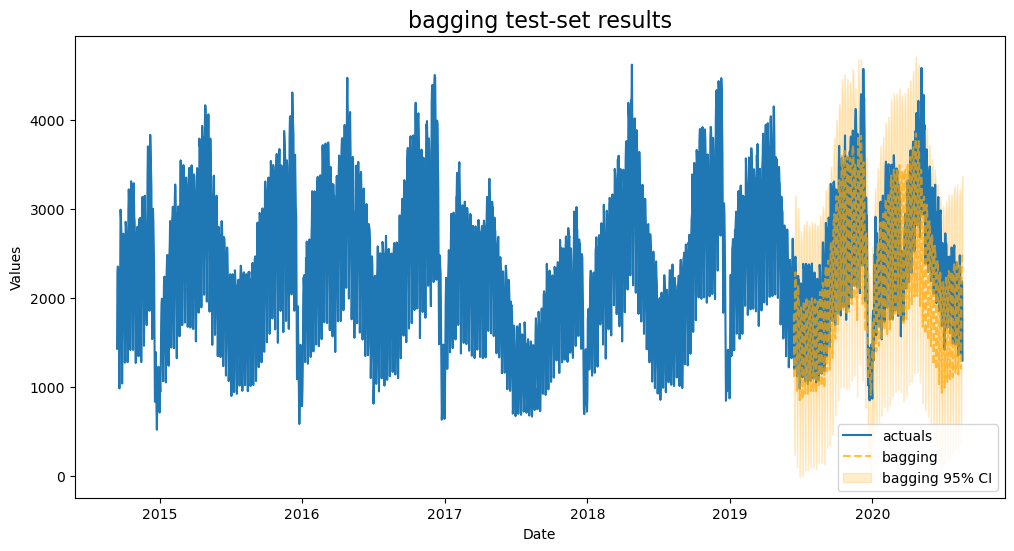

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,knn,"{'n_neighbors': 20, 'weights': 'uniform'}",0.130121,0.713268,0.117198,0.873220
2,bagging,"{'base_estimator': MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver='lbfgs'), 'max_samples': 0.9, 'max_features': 0.5}",0.130137,0.714881,0.050964,0.967984
3,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
4,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
5,mlr,{},0.144850,0.733553,0.064183,0.953482
6,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 1, 'learning_rate': 'constant'}",0.166129,0.609554,0.065153,0.951795
7,lightgbm,"{'n_estimators': 200, 'boosting_type': 'goss', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0.25, 'reg_lambda': 1.0, 'num_leaves': 35}",0.166747,0.592318,0.050726,0.970159
8,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719
9,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'auto', 'max_samples': 0.75}",0.318096,-0.916329,0.083374,0.918095


In [29]:
plot_test_export_summaries(f)

This is the best-performing model yet, with less overfitting than XGBoost and KNN.

## StackingRegressor
This model will use the predictions of other models as inputs to a "final estimator". It's added complexity can mean better performance, although not always.

![Stacking Regressor](stacking.png)

The model that we employ uses the bagged MLP regressor from the previous section as its final estimator, and the tuned knn, xgboost, lightgbm, and sgd models as its inputs.

![MLP Stack](mlp_stack.png)

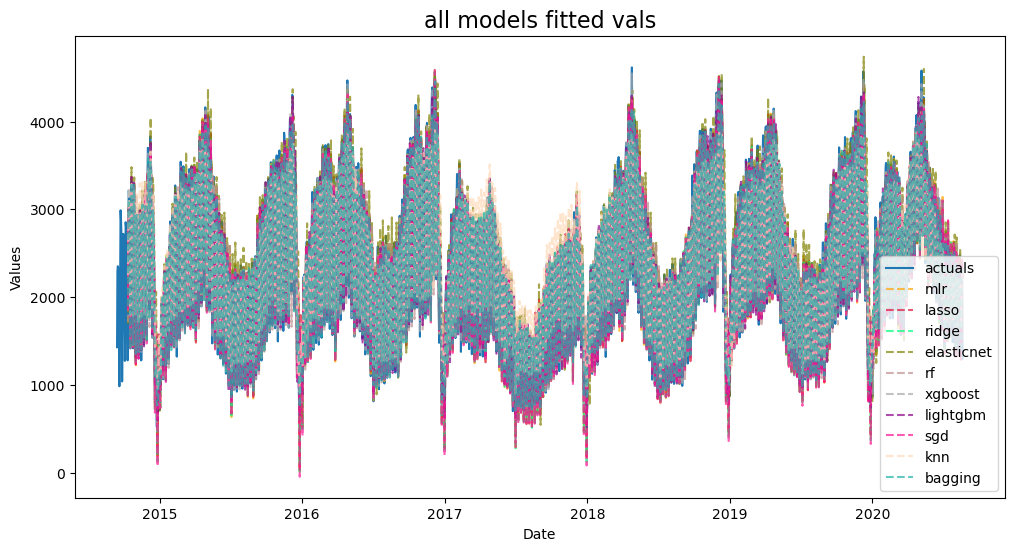

In [30]:
f.plot_fitted()
plt.title('all models fitted vals',size=16)
plt.show()

Sometimes seeing the fitted values can give a good idea of which models to stack, as you want models that can predict both the highs and lows of the series. However, this graph didn't tell us much.  

We use four of our best performing models to create the model inputs. We use a bagging estimator as the final model.  

In [31]:
f.set_estimator('stacking')
results = f.export('model_summaries')
estimators = [
    'knn',
    'xgboost',
    'lightgbm',
    'sgd',
]

mlp_stack(f,estimators,call_me='stacking')

Finished loading model, total used 200 iterations


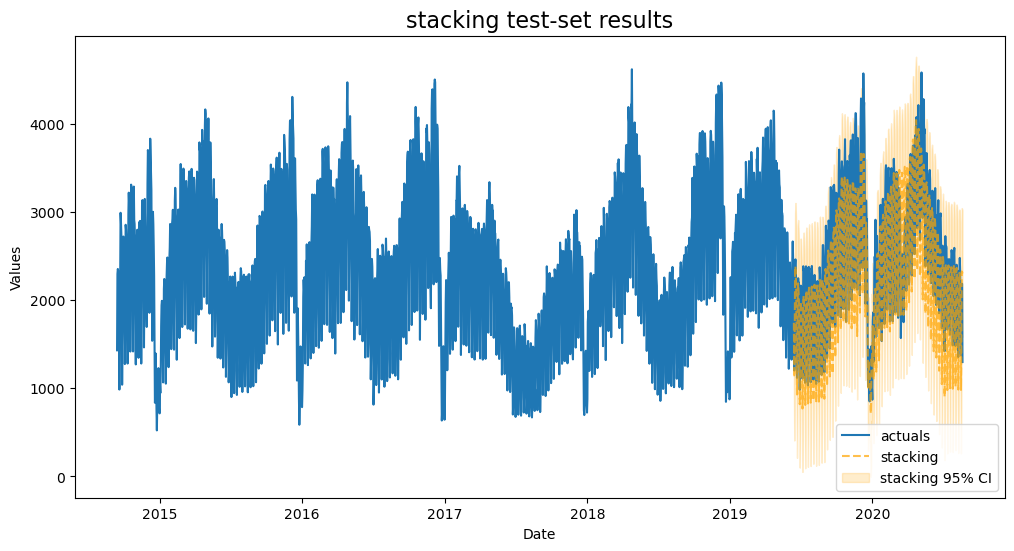

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.9}",0.115551,0.769377,0.018676,0.995667
1,stacking,"{'estimators': [('knn', KNeighborsRegressor(n_neighbors=20)), ('xgboost', XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=5, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, ...",0.122353,0.784423,0.040845,0.979992
2,knn,"{'n_neighbors': 20, 'weights': 'uniform'}",0.130121,0.713268,0.117198,0.873220
3,bagging,"{'base_estimator': MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver='lbfgs'), 'max_samples': 0.9, 'max_features': 0.5}",0.130137,0.714881,0.050964,0.967984
4,lasso,{'alpha': 0.32323232323232326},0.139526,0.744279,0.065458,0.952205
5,ridge,{'alpha': 0.6060606060606061},0.140560,0.743738,0.064592,0.952812
6,mlr,{},0.144850,0.733553,0.064183,0.953482
7,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 1, 'learning_rate': 'constant'}",0.166129,0.609554,0.065153,0.951795
8,lightgbm,"{'n_estimators': 200, 'boosting_type': 'goss', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0.25, 'reg_lambda': 1.0, 'num_leaves': 35}",0.166747,0.592318,0.050726,0.970159
9,elasticnet,"{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': None}",0.259322,0.152033,0.092402,0.904719


In [32]:
plot_test_export_summaries(f)

This is our best model with lower amounts of overfitting than some of our other models. We will choose it to make our final forecasts with.

## Plot Forecast

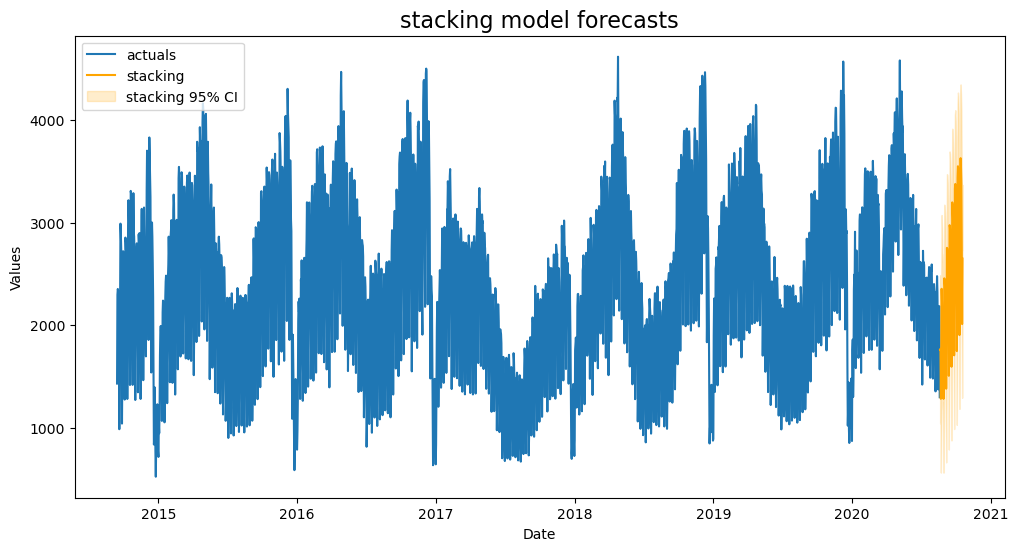

In [33]:
f.plot('stacking',ci=True)
plt.title('stacking model forecasts',size=16)
plt.show()